In [ ]:
# https://ibkrcampus.com/campus/ibkr-api-page/twsapi-doc/#api-introduction
#pip install requests
# https://stackoverflow.com/questions/8548030/why-does-pip-install-inside-python-raise-a-syntaxerror

In [1]:
from ib_insync import *
import requests
import pandas as pd
from bs4 import BeautifulSoup

util.startLoop()  # only use in interactive environments (i.e. Jupyter Notebooks)
# https://algotrading101.com/learn/ib_insync-interactive-brokers-api-guide/

In [2]:
#WORKING
ib = IB()
ib.connect(host='127.0.0.1', port=7496, clientId=0)
# https://www.elitetrader.com/et/threads/cant-connect-to-api-interactive-brokers.361205/
# needed to change socket port to 7496 and uncheck the Read-Only API box

<IB connected to 127.0.0.1:7496 clientId=0>

In [3]:
ib.positions()

[Position(account='U12848716', contract=Stock(conId=700941285, symbol='NUVOQ', exchange='PINK', currency='USD', localSymbol='NUVOQ', tradingClass='NUVOQ'), position=275.0, avgCost=0.24124875)]

In [4]:
pending_trades = ib.reqOpenOrders() # requires that I use ClientId=0 rather than ClientId=1
# https://www.reddit.com/r/interactivebrokers/comments/119begz/cant_see_open_orders_via_api/
pending_trades

[Trade(contract=Stock(conId=641842650, symbol='DRUG', right='?', exchange='SMART', currency='USD', localSymbol='DRUG', tradingClass='SCM'), order=Order(orderId=-4, permId=887072239, action='BUY', totalQuantity=1.0, orderType='LMT', lmtPrice=0.0155, auxPrice=0.0, tif='GTC', ocaType=3, displaySize=2147483647, rule80A='0', openClose='', volatilityType=0, deltaNeutralOrderType='None', referencePriceType=0, account='U12848716', clearingIntent='IB', adjustedOrderType='None', cashQty=0.0, dontUseAutoPriceForHedge=True), orderStatus=OrderStatus(orderId=-4, status='PreSubmitted', filled=0.0, remaining=1.0, avgFillPrice=0.0, permId=887072239, parentId=0, lastFillPrice=0.0, clientId=0, whyHeld='', mktCapPrice=0.0), fills=[], log=[TradeLogEntry(time=datetime.datetime(2024, 11, 13, 3, 37, 58, 651430, tzinfo=datetime.timezone.utc), status='PreSubmitted', message='', errorCode=0)], advancedError=''),
 Trade(contract=Stock(conId=528660539, symbol='CERO', right='?', exchange='SMART', currency='USD', lo

In [5]:
symbols = [trade.contract.symbol for trade in pending_trades]
print(symbols)

['DRUG', 'CERO']


In [6]:
handling_code = [trade.order.lmtPrice for trade in pending_trades]
print(handling_code)

[0.0155, 0.0155]


In [7]:
# https://github.com/Siloaman/ib_async/blob/main/notebooks/bar_data.ipynb
# To get the earliest date of available bar data the "head timestamp" can be requested:
contract = Stock('TSLA', 'SMART', 'USD')
ib.reqHeadTimeStamp(contract, whatToShow='TRADES', useRTH=True)

datetime.datetime(2010, 6, 29, 8, 0)

In [8]:
# Legal ones are: 
# 1 secs, 5 secs, 10 secs, 15 secs, 30 secs, 
# 1 min, 2 mins, 3 mins, 5 mins, 10 mins, 15 mins, 20 mins, 30 mins, 
# 1 hour, 2 hours, 3 hours, 4 hours, 8 hours, 
# 1 day, 1W, 1M
# To request hourly data of the last 1 day per 5 minutes:
bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr='1 D',
        barSizeSetting='5 mins',
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1)

bars[0]

BarData(date=datetime.datetime(2024, 11, 12, 9, 30, tzinfo=zoneinfo.ZoneInfo(key='US/Eastern')), open=342.74, high=345.84, low=335.3, close=340.43, volume=5546777.0, average=339.927, barCount=21909)

In [9]:
df = util.df(bars)
display(df.tail(8))

,date,open,high,low,close,volume,average,barCount
70,2024-11-12 15:20:00-05:00,329.47,330.24,328.76,329.22,686254.0,329.533,3025
71,2024-11-12 15:25:00-05:00,329.19,329.29,327.50,328.34,1207869.0,328.230,5137
72,2024-11-12 15:30:00-05:00,328.40,328.49,326.28,326.44,1049160.0,327.202,5112
73,2024-11-12 15:35:00-05:00,326.50,328.78,326.11,328.60,1241768.0,327.485,5356
74,2024-11-12 15:40:00-05:00,328.59,329.68,328.10,328.91,966654.0,328.950,4018
75,2024-11-12 15:45:00-05:00,328.92,329.20,327.45,328.02,1010562.0,328.328,4599
76,2024-11-12 15:50:00-05:00,327.98,329.31,327.02,329.00,1196537.0,327.995,6029
77,2024-11-12 15:55:00-05:00,328.94,329.45,327.90,328.25,1854333.0,328.757,9457


In [10]:
%matplotlib inline

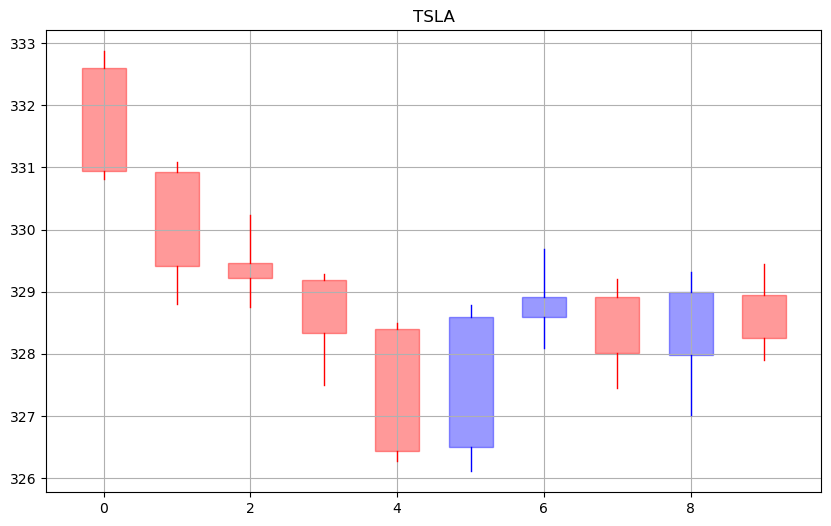

In [11]:
# There is also a utility function to plot bars as a candlestick plot. 
# It can accept either a DataFrame or a list of bars.
# Here it will print the last 10 bars:
util.barplot(bars[-10:], title=contract.symbol);

In [ ]:
# A new feature of the API is to get live updates for historical bars.
# This is done by setting endDateTime to an empty string and the keepUpToDate parameter to True.
bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr='480 S',          # 5 mins x 8 bars (60 x 8)
        barSizeSetting='5 mins',
        whatToShow='MIDPOINT',
        useRTH=True,
        formatDate=1,
        keepUpToDate=True)

In [ ]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

def onBarUpdate(bars, hasNewBar):
    plt.close()
    plot = util.barplot(bars)
    clear_output(wait=True)
    display(plot)

bars.updateEvent += onBarUpdate

ib.sleep(10)
ib.cancelHistoricalData(bars)

In [13]:
# WORKING
acct_values = ib.accountValues()
#cash_balance = acct_values

#    [
#    AccountValue(account='U12848716', tag='AccountCode', value='U12848716', currency='', modelCode=''),
#    AccountValue(account='U12848716', tag='CashBalance', value='517.53', currency='USD', modelCode=''),
#    AccountValue(account='U12848716', tag='GrossPositionValue', value='1.58', currency='CAD', modelCode=''),
#    AccountValue(account='U12848716', tag='NetLiquidation', value='723.69', currency='CAD', modelCode=''),
#    AccountValue(account='U12848716', tag='TotalCashBalance', value='2.24', currency='CAD', modelCode=''),
#    AccountValue(account='U12848716', tag='TotalCashBalance', value='517.53', currency='USD', modelCode=''),
#    ]

Get Overall USD Cash Balance

In [14]:
# WORKING
def get_cash_balance_usd(acct_values):
    for item in acct_values:
        # AccountValue(account='U12848716', tag='CashBalance', value='517.53', currency='USD', modelCode=''),
        if item[1] == 'CashBalance' and item[3] == 'USD':
            return float(item[2])  # Convert value to float for numerical use

# Get the CashBalance in USD
cash_balance_usd = get_cash_balance_usd(acct_values)
cash_balance_usd

494.39

# Retrieving Historical Data

In [ ]:
# for this to work, Market Data Subscriber Status needs to be updated for a subscription

nflx_contract = Stock('mlgo', 'SMART', 'USD')     # netflix ticker, 'smart' search for routing exchange, currency of ticker

ib.qualifyContracts(nflx_contract)

data = ib.reqMktData(nflx_contract)

In [ ]:
historical_data_nflx = ib.reqHistoricalData(
    nflx_contract, 
    '', 
    barSizeSetting='5 mins', 
    durationStr='1 D', 
    whatToShow='MIDPOINT', 
    useRTH=True
    )

historical_data_nflx[-6]      #  access the most recent candle, just like any other Python list, by using a negative index.
# https://www.interactivebrokers.com/campus/ibkr-api-page/market-data-subscriptions/
#historical_data_nflx[-1].open

In [ ]:
ib.run()